In [4]:
import pandas as pd


In [5]:
!pip install 
!pip install textblob


ERROR: You must give at least one requirement to install (see "pip help install")


In [ ]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import time
from tqdm import tqdm  # progress bar

# Reddit credentials
reddit = praw.Reddit(
    client_id="",
    client_secret="",
    user_agent="wh1000xm4-analysis by /u/InternationalDog7682"
)

# Parameters
subreddits = ["SonyHeadphones", "HeadphoneAdvice", "headphones"]
query = "WH-1000XM4"

# Define each video release date
videos = {
    "Short_Mar2023": datetime(2023, 3, 15),
    "Long_Aug2020": datetime(2020, 8, 13),
    "Short_Nov2022": datetime(2022, 11, 6),
    "Long_Dec2020": datetime(2020, 12, 18)
}

# Set a general scraping range (earliest and latest across videos)
global_start_date = datetime(2020, 7, 1)    # Early enough
global_end_date = datetime(2023, 5, 1)      # Late enough

comments_data = []

# Loop through each subreddit
for subreddit in subreddits:
    print(f"\n📥 Scraping r/{subreddit}...")
    try:
        posts = list(reddit.subreddit(subreddit).search(query, limit=500))  # pull more posts if you can
    except Exception as e:
        print(f"❌ Could not load posts from r/{subreddit}: {e}")
        continue

    for post in tqdm(posts, desc=f"Posts in r/{subreddit}"):
        try:
            post.comments.replace_more(limit=0)
            for comment in post.comments:
                comment_time = datetime.utcfromtimestamp(comment.created_utc)
                
                # Only keep comments within global range
                if global_start_date <= comment_time <= global_end_date:
                    
                    # Check which video it belongs to
                    for video_name, video_date in videos.items():
                        window_start = video_date - timedelta(weeks=2)  # 2 weeks before
                        window_end = video_date + timedelta(weeks=6)    # 6 weeks after
                        
                        if window_start <= comment_time <= window_end:
                            label = "Before" if comment_time < video_date else "After"
                            comments_data.append({
                                "subreddit": subreddit,
                            "comment_text": comment.body,
                            "comment_time": comment_time,
                            "comment_score": comment.score,             # ✨ New
                            "post_score": post.score,                    # ✨ New
                            "post_num_comments": post.num_comments,      # ✨ New
                            "post_upvote_ratio": post.upvote_ratio,       # ✨ New
                            "video": video_name,
                            "before_after": label
                            })
                            break  # stop checking other videos if matched
            time.sleep(1)  # polite delay between posts
        except Exception as e:
            print(f"⚠️ Error on post '{post.title}': {e}")
            time.sleep(2)

# Convert to DataFrame and save
comments_df = pd.DataFrame(comments_data)
comments_df.to_csv("reddit_comments_by_video.csv", index=False)
print("\n✅ Done! Data saved to 'reddit_comments_by_video.csv'")



📥 Scraping r/SonyHeadphones...


Posts in r/SonyHeadphones: 100%|██████████| 246/246 [05:13<00:00,  1.28s/it]



📥 Scraping r/HeadphoneAdvice...


Posts in r/HeadphoneAdvice: 100%|██████████| 237/237 [04:44<00:00,  1.20s/it]



📥 Scraping r/headphones...


Posts in r/headphones: 100%|██████████| 232/232 [04:55<00:00,  1.27s/it]


✅ Done! Data saved to 'reddit_comments_by_video.csv'


In [25]:
from textblob import TextBlob

def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

comments_df["sentiment"] = comments_df["comment_text"].apply(get_sentiment)



In [35]:
comments_df['comment_date'] = pd.to_datetime(comments_df['comment_time']).dt.date
comments_df


,subreddit,comment_text,comment_time,comment_score,post_score,post_num_comments,post_upvote_ratio,video,before_after,sentiment,tiktok_mention,youtube_mention,comment_date,sentiment_score
0,SonyHeadphones,Just chiming in to say that this worked for me...,2022-11-01 13:19:29,1,375,352,1.00,Short_Nov2022,Before,Neutral,False,False,2022-11-01,Neutral
1,SonyHeadphones,I just returned the second pair of those headp...,2022-11-25 16:46:33,1,375,352,1.00,Short_Nov2022,After,Neutral,False,False,2022-11-25,Neutral
2,SonyHeadphones,Woah.... It worked WTF????,2022-12-04 15:25:30,1,375,352,1.00,Short_Nov2022,After,Negative,False,False,2022-12-04,Negative
3,SonyHeadphones,I think I found the fix. Run the optimiser in ...,2023-03-16 11:47:07,1,375,352,1.00,Short_Mar2023,After,Neutral,False,False,2023-03-16,Neutral
4,SonyHeadphones,[removed],2023-03-20 06:57:23,1,375,352,1.00,Short_Mar2023,After,Neutral,False,False,2023-03-20,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,headphones,Cleer Alpha or Cleer Enduro ANC,2022-11-04 04:07:18,1,12,21,0.87,Short_Nov2022,Before,Neutral,False,False,2022-11-04,Neutral
372,headphones,So I think you’re going to have to concede on ...,2022-11-04 04:25:29,1,12,21,0.87,Short_Nov2022,Before,Neutral,False,False,2022-11-04,Neutral
373,headphones,https://www.bowerswilkins.com/en-us/product/he...,2022-11-04 04:26:08,1,12,21,0.87,Short_Nov2022,Before,Negative,False,False,2022-11-04,Negative
374,headphones,I have the bose 700 (using them now at an airp...,2022-11-04 13:49:25,1,12,21,0.87,Short_Nov2022,Before,Positive,False,False,2022-11-04,Positive


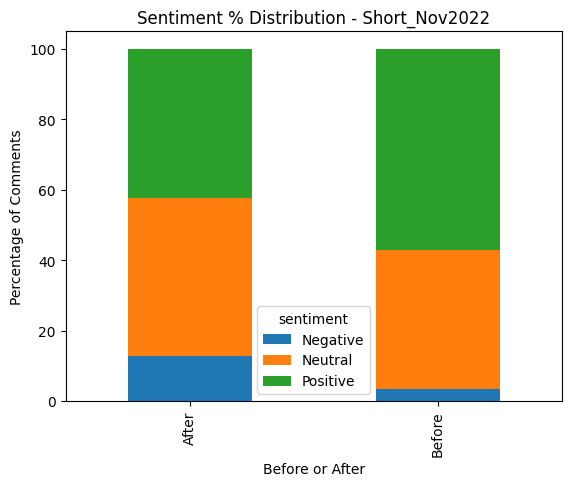

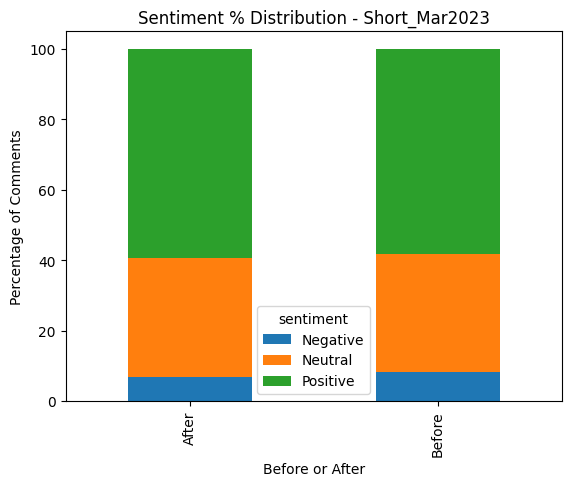

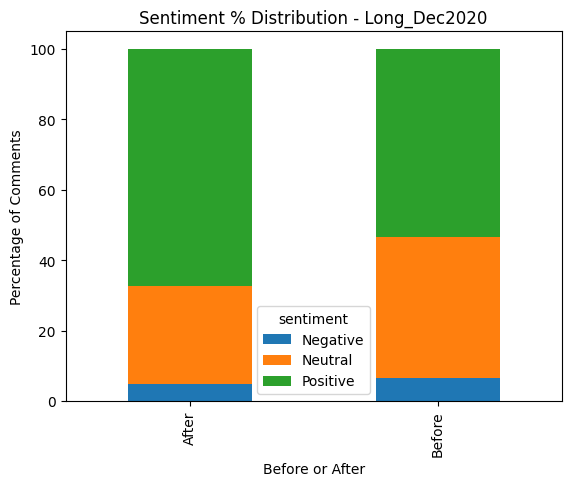

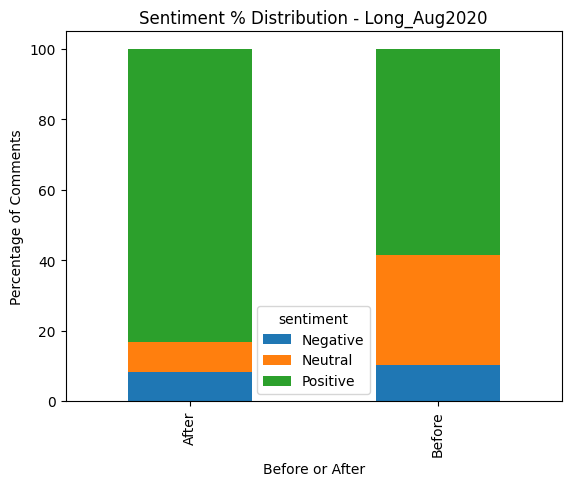

In [26]:
for video in comments_df['video'].unique():
    subset = comments_df[comments_df['video'] == video]
    sentiment_counts = subset.groupby('before_after')['sentiment'].value_counts(normalize=True).unstack() * 100

    sentiment_counts.plot(kind='bar', stacked=True, title=f"Sentiment % Distribution - {video}")
    plt.xlabel("Before or After")
    plt.ylabel("Percentage of Comments")
    plt.show()


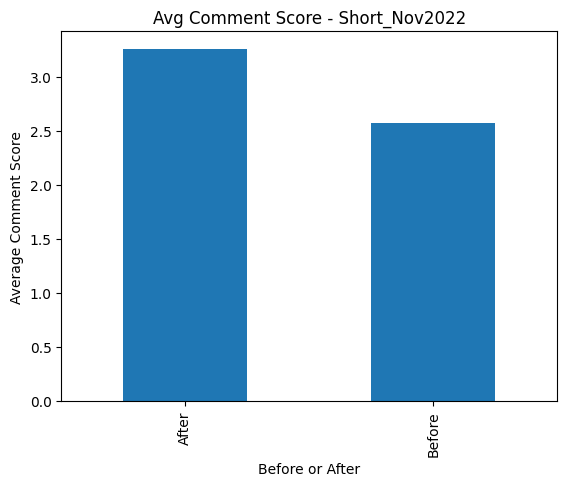

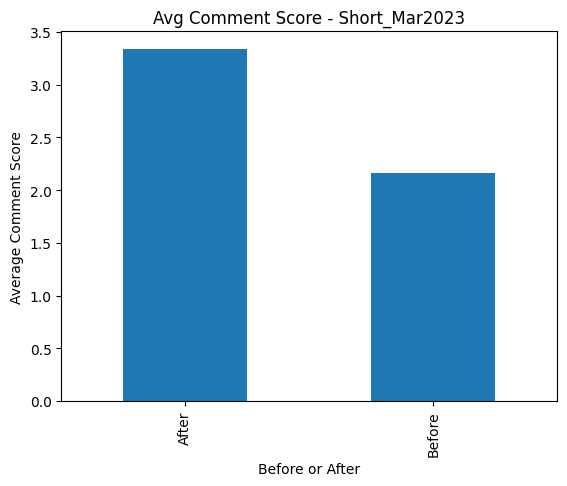

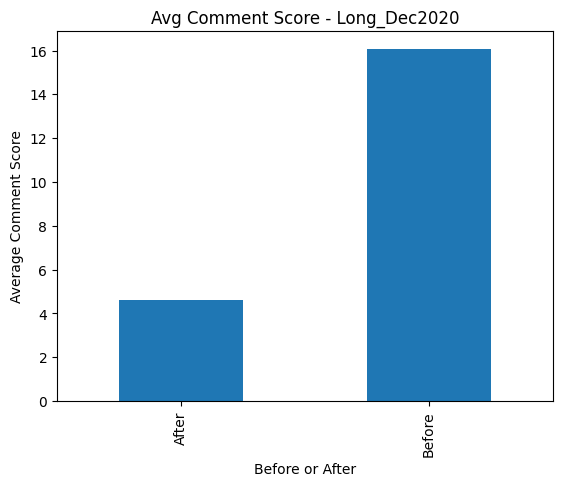

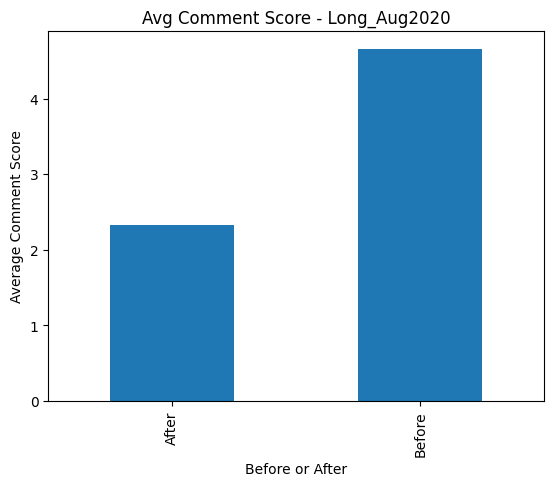

In [27]:
for video in comments_df['video'].unique():
    subset = comments_df[comments_df['video'] == video]
    avg_c_score = subset.groupby('before_after')['comment_score'].mean()

    avg_c_score.plot(kind='bar', title=f"Avg Comment Score - {video}")
    plt.xlabel("Before or After")
    plt.ylabel("Average Comment Score")
    plt.show()


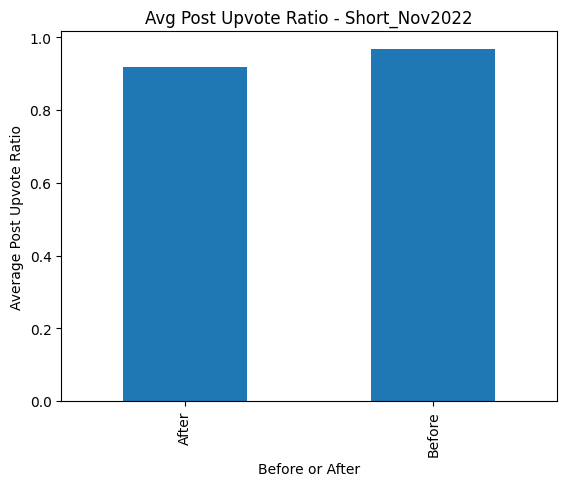

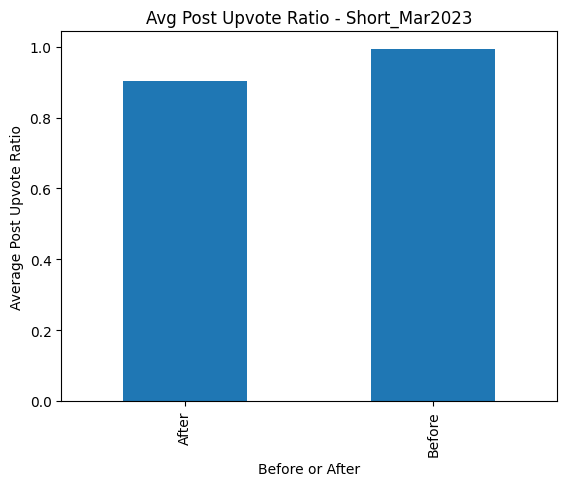

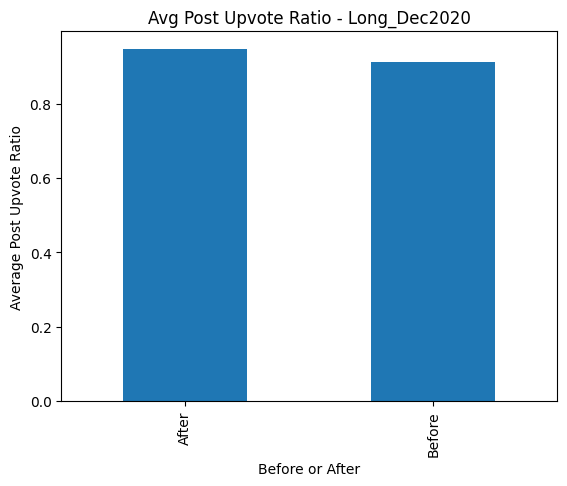

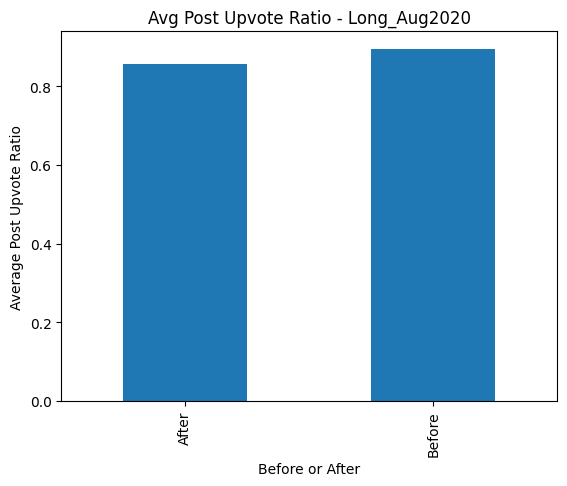

In [30]:
for video in comments_df['video'].unique():
    subset = comments_df[comments_df['video'] == video]
    avg_upvote_ratio = subset.groupby('before_after')['post_upvote_ratio'].mean()

    avg_upvote_ratio.plot(kind='bar', title=f"Avg Post Upvote Ratio - {video}")
    plt.xlabel("Before or After")
    plt.ylabel("Average Post Upvote Ratio")
    plt.show()

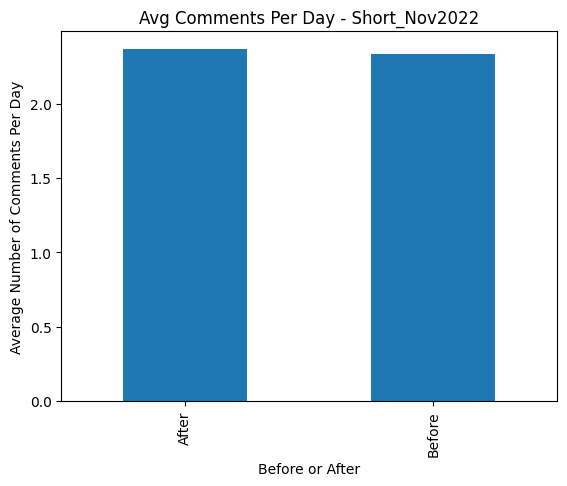

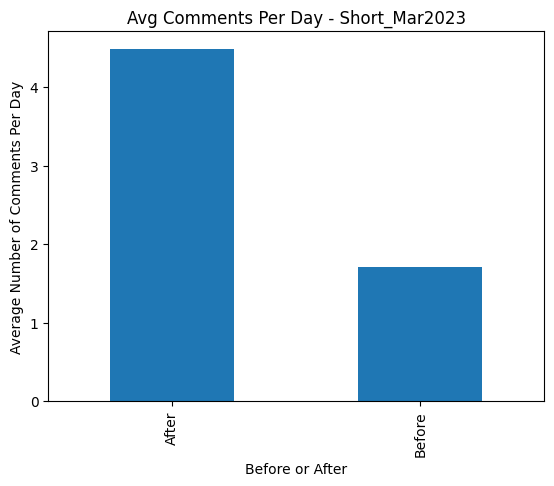

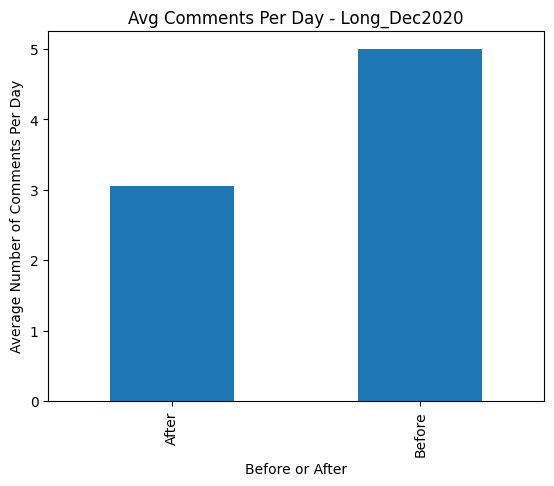

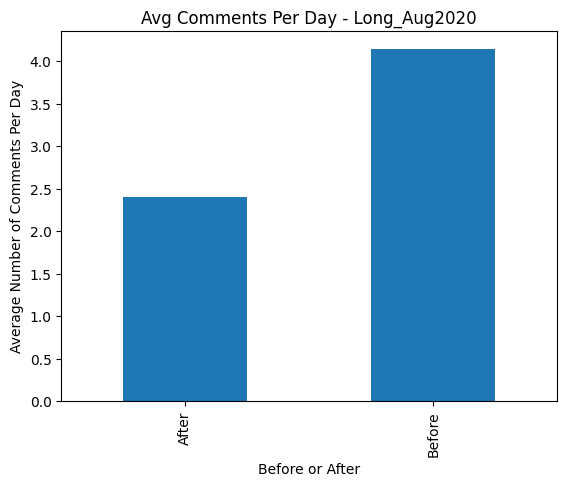

In [31]:
for video in comments_df['video'].unique():
    subset = comments_df[comments_df['video'] == video]
    comments_per_day = subset.groupby(['before_after', 'comment_date']).size().groupby(level=0).mean()

    comments_per_day.plot(kind='bar', title=f"Avg Comments Per Day - {video}")
    plt.xlabel("Before or After")
    plt.ylabel("Average Number of Comments Per Day")
    plt.show()

In [36]:
missing_summary = comments_df.isnull().sum()
print(missing_summary)

subreddit            0
comment_text         0
comment_time         0
comment_score        0
post_score           0
post_num_comments    0
post_upvote_ratio    0
video                0
before_after         0
sentiment            0
tiktok_mention       0
youtube_mention      0
comment_date         0
sentiment_score      0
dtype: int64


Chat GPT 4.0 was used for code